# Setup

In [6]:
include(joinpath("..","src","setup.jl"))

RObject{VecSxp}
$rcalljl_options
$rcalljl_options$width
[1] 800

$rcalljl_options$height
[1] 400




In [114]:
paramfile = joinpath("..","data","count_lengths","run_2018-09-12",
                     "individual_extremes_params.feather")
params = getparams(paramfile) do i,row
  abs(row[:t_c_m] - 32) < 1 &&
  abs(row[:t_c_a] - 5) < 1 &&
  row[:Δf] == 12
end

params[:t_W_m_σ_t] = 7.0
params[:t_W_m_σ_ϕ] = 7.0
params[:t_W_m_c] = 4.0

settings = TOML.parsefile(joinpath(src,"settings.toml"))
settings["track"]["analyze"]["freq_ridge"] = 2
settings["track"]["analyze"]["scale_ridge"] = 1e-6

1.0e-6

## some examples of the distance function for ridge definition

In [115]:
d = rdist(scale=1e-6,freq=3)
@show exp(-d((1,1),(1,1)))
@show exp(-d((1,1),(1,2)))
@show exp(-d((1,1),(1,3)))
@show exp(-d((1,1),(1,4)))
@show exp(-d((1,1),(1,5)))
@show exp(-d((1,1),(1,6)))
@show exp(-d((1,1),(2,1)))
@show exp(-d((1,1),(2,2)))
@show exp(-d((1,1),(2,3)))

exp(-(d((1, 1), (1, 1)))) = 1.0
exp(-(d((1, 1), (1, 2)))) = 0.8948393168143698
exp(-(d((1, 1), (1, 3)))) = 0.6411803884299546
exp(-(d((1, 1), (1, 4)))) = 0.36787944117144233
exp(-(d((1, 1), (1, 5)))) = 0.1690133154060661
exp(-(d((1, 1), (1, 6)))) = 0.06217652402211632
exp(-(d((1, 1), (2, 1)))) = 0.0
exp(-(d((1, 1), (2, 2)))) = 0.0
exp(-(d((1, 1), (2, 3)))) = 0.0


0.0

# distances of simplified (simple) frames

In [152]:
using Unitful
using AxisArrays
a = AuditoryBistabilityLE.tone(500Hz,1s)
b = AuditoryBistabilityLE.tone(600Hz,1s)
set = AuditoryBistabilityLE.read_settings(settings)
l,u = set.rates.freq_limits_Hz.*Hz
A = cortical(audiospect(a;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
B = cortical(audiospect(b;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
pred(abs.(A[1,:,:]),abs.(B[1,:,:]))

6.166511119084703

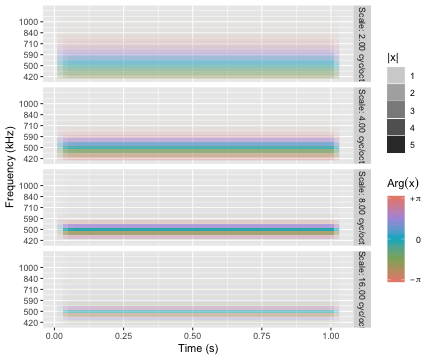

RObject{VecSxp}


In [153]:
rplot(A)

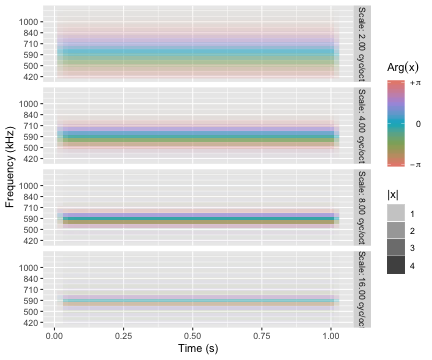

RObject{VecSxp}


In [154]:
rplot(B)

In [155]:
a = AuditoryBistabilityLE.tone(500Hz,1s)
b = AuditoryBistabilityLE.tone(1000Hz,1s)
set = AuditoryBistabilityLE.read_settings(settings)
l,u = set.rates.freq_limits_Hz.*Hz
A = cortical(audiospect(a;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
B = cortical(audiospect(b;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
pred(abs.(A[1,:,:]),abs.(B[1,:,:]))

-29.603038127389553

In [157]:
function fpred(f1,f2)
    a = AuditoryBistabilityLE.tone(f1,1s)
    b = AuditoryBistabilityLE.tone(f2,1s)
    set = AuditoryBistabilityLE.read_settings(settings)
    l,u = set.rates.freq_limits_Hz.*Hz
    A = cortical(audiospect(a;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
    B = cortical(audiospect(b;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
    pred(abs.(A[1,:,:]),abs.(B[1,:,:]))
end

fpred (generic function with 1 method)

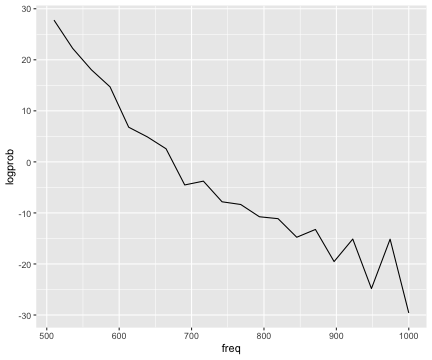

RObject{VecSxp}


In [162]:
fs = range(510,stop=1000,length=20)
vals = map(fs) do f
    fpred(500Hz,f*Hz)
end
R"""qplot(x=$fs,y=$vals,geom='line') + xlab('freq') + ylab('logprob')"""

# distances of actual frames

In [116]:
settings["track"]["analyze"]["max_sources"] = 2
settings["track"]["analyze"]["normalize"] = true
settings["track"]["analyze"]["min_norm"] = 0.2

result = []
for d in [1,3,6,12]
  params[:Δf] = d
  push!(result,bistable_model(15,params,settings,progressbar=false,
                              intermediate_results=true))
end

┌ Warning: Deprecated syntax `implicit assignment to global variable `d``.
│ Use `global d` instead.
└ @ nothing none:0
┌ Warning: Loop variable `d` around In[116]:6 overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ nothing In[116]:6
┌ Info: 2.78% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44
┌ Info: Sparsity of source-prior (76 × 76) ridge: 280 (5%)
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/priors/ridge_norm.jl:31
┌ Info: Sparsity of source-prior (76 × 76) ridge: 280 (5%)
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/priors/ridge_norm.jl:31
┌ Info: Sparsity of source-prior (76 × 76) ridge: 280 (5%)
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/priors/ridge_norm.jl:31
┌ Info: Sparsi

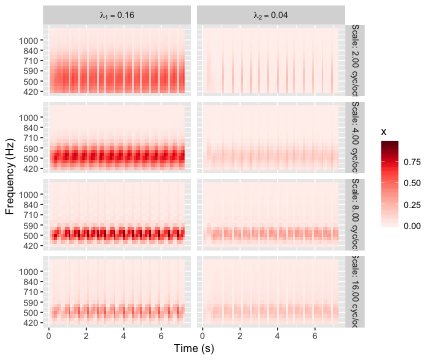

RObject{VecSxp}


In [117]:
rplot(result[1].cohere)

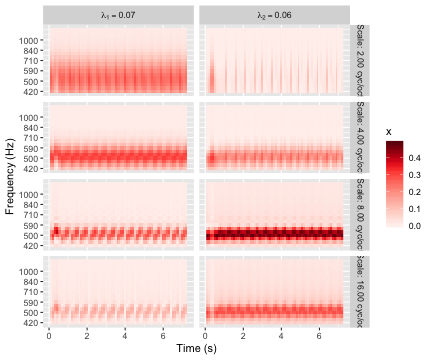

RObject{VecSxp}


In [118]:
rplot(result[1].sources.tracks[1])

In [119]:
sum(result[1].sources.tracks[1].params.source_prior.corr .> 0)

484

In [120]:
sum(result[1].sources.tracks[1].params.source_prior.corr.data .> 0)

280

In [142]:
size(result[1].sources.tracks[1].params.source_prior.corr)

(76, 76)

In [ ]:
ShammaModel.raster_plot(result[1].sources.tracks[1].params.source_prior.corr)

In [193]:
function pred(x,y)
    pr = deepcopy(result[1].sources.tracks[1].params.source_prior)
    like = zero(pr,prod((size(result[1].cohere,2),size(result[1].cohere,3))))
    AuditoryBistabilityLE.update!(like,vec(x))
    AuditoryBistabilityLE.logpdf(pr + like,vec(y))
end

pred (generic function with 1 method)

In [194]:
for i in 50:59
    @show pred(result[1].cohere[i,:,:,1],result[1].cohere[i+1,:,:,1])
end

pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 83.65173339994715
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 78.09160920300388
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 83.34264043541765
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 81.18174909240861
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 84.59511148655524
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 83.60945538443946
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 78.89943866212852
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 83.5354154344721
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 80.4787362392299
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 83.72984392638821


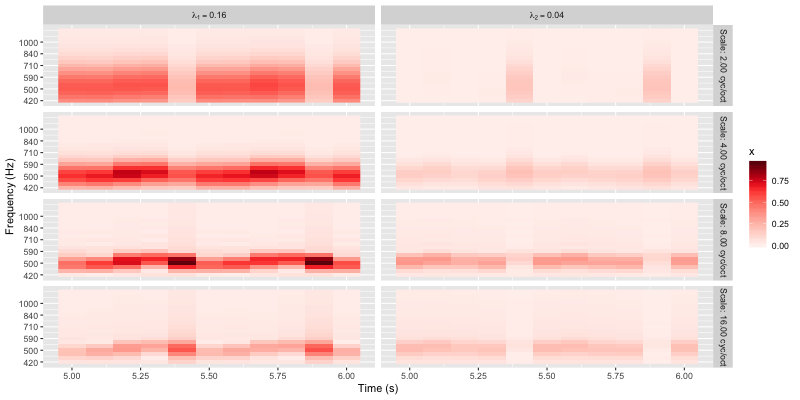

RObject{VecSxp}


In [195]:
rplot(result[1].cohere[50:60,:,:,:])

In [197]:
for i in 50:59
    @show pred(result[2].cohere[i,:,:,1],result[2].cohere[i+1,:,:,1])
end

pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 80.74650025065293
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 69.75922443715817
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 80.66150093216746
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 68.09215229404232
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 86.10418370436453
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 79.02848992707806
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 68.4274016812482
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 81.36316839916739
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 69.57155114172801
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 86.17350758761145


In [198]:
for i in 50:59
    @show pred(result[3].cohere[i,:,:,1],result[3].cohere[i+1,:,:,1])
end

pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 78.18856661381955
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 77.3057787107225
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 82.14351299960853
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 80.23515884835027
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 82.23905556953979
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 77.71903502165469
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 76.44013870545344
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 79.3369608178073
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 72.21609343571723
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 83.16448292519087


In [196]:
for i in 50:59
    @show pred(result[4].cohere[i,:,:,1],result[4].cohere[i+1,:,:,1])
end

pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 77.58257065220582
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 75.62675424916137
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 79.9737536066424
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 76.26383714191377
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 72.33060147086057
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 76.50578320462249
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 74.23711741588869
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 74.93617109327019
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 77.42848673718902
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 74.22244586194195


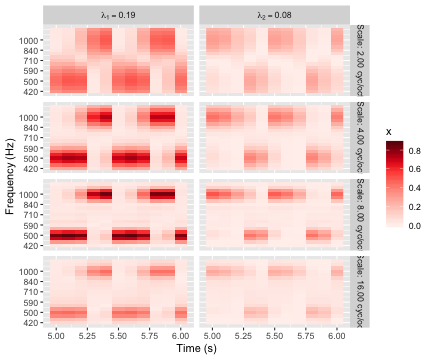

RObject{VecSxp}


In [169]:
rplot(result[4].cohere[50:60,:,:,:])

# Percept testing

In [223]:
settings = TOML.parsefile(joinpath(src,"settings.toml"))
settings["track"]["analyze"]["freq_ridge"] = 3.5
settings["track"]["analyze"]["scale_ridge"] = 1e-8
settings["track"]["analyze"]["source_prior_sds"] = [4.0,16.0,32.0,64.0,128.0]
settings["track"]["analyze"]["time_constants_s"] = [1.0,8.0,16.0]

settings["track"]["analyze"]["max_sources"] = 2
settings["track"]["analyze"]["normalize"] = true
settings["track"]["analyze"]["min_norm"] = 0.2

result = []
for d in [1,3,6,12]
 params[:Δf] = d
  push!(result,bistable_model(15,params,settings,progressbar=false,
                              intermediate_results=true))
end

┌ Warning: Deprecated syntax `implicit assignment to global variable `d``.
│ Use `global d` instead.
└ @ nothing none:0
┌ Warning: Loop variable `d` around In[223]:12 overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ nothing In[223]:12
┌ Info: 2.78% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44
┌ Info: Sparsity of source-prior (76 × 76) ridge: 448 (8%)
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/priors/ridge_norm.jl:31
┌ Info: Sparsity of source-prior (76 × 76) ridge: 448 (8%)
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/priors/ridge_norm.jl:31
┌ Info: Sparsity of source-prior (76 × 76) ridge: 448 (8%)
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/priors/ridge_norm.jl:31
┌ Info: Spar

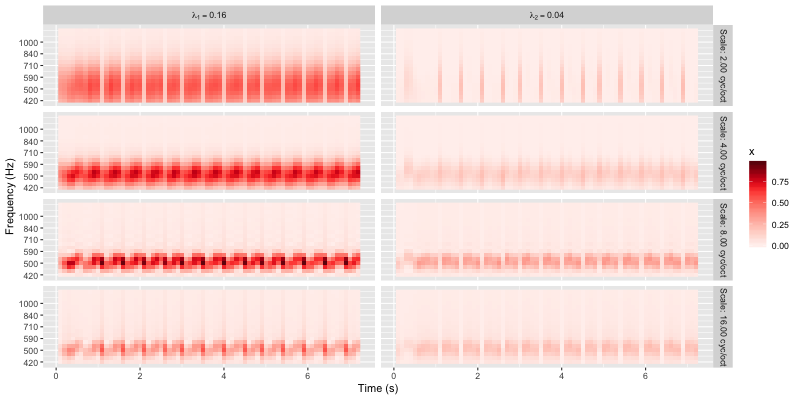

RObject{VecSxp}


In [224]:
rplot(result[1].cohere)

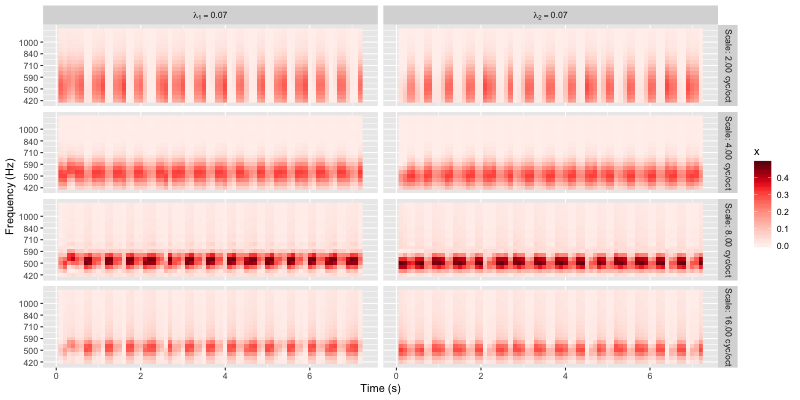

RObject{VecSxp}


In [225]:
rplot(result[1].sources.tracks[1])

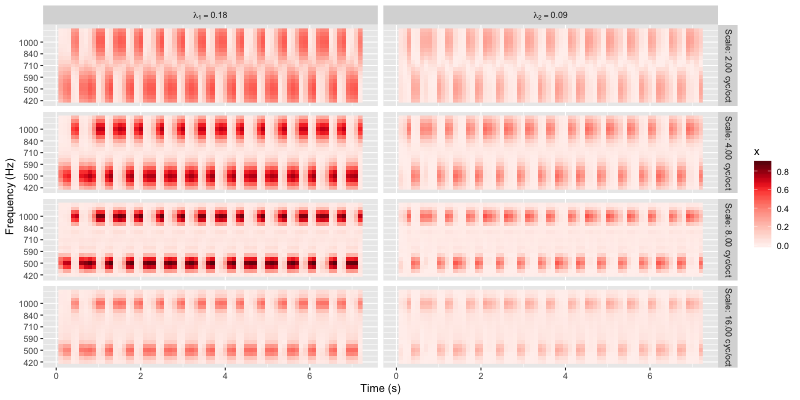

RObject{VecSxp}


In [227]:
rplot(result[4].cohere)

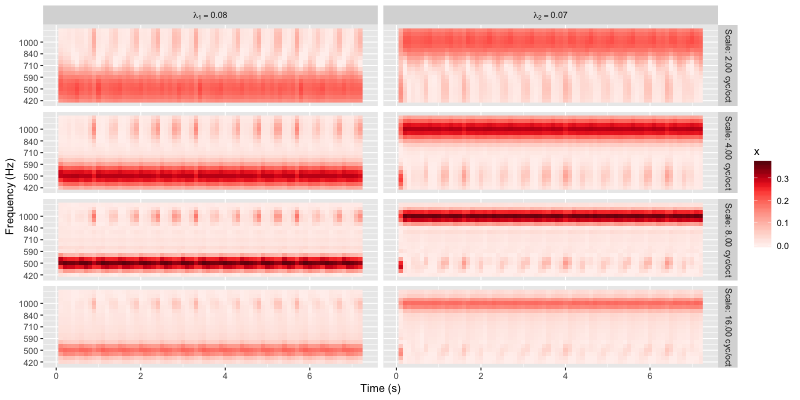

RObject{VecSxp}


In [228]:
rplot(result[4].sources.tracks[1])

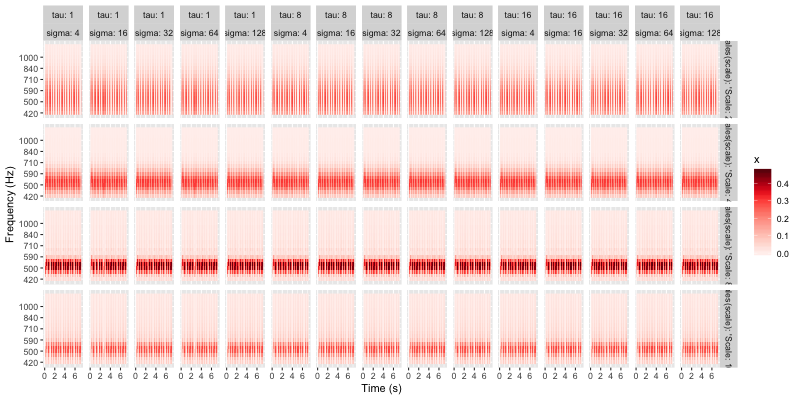

RObject{VecSxp}


In [229]:
rplot(result[1].sources.tracks)

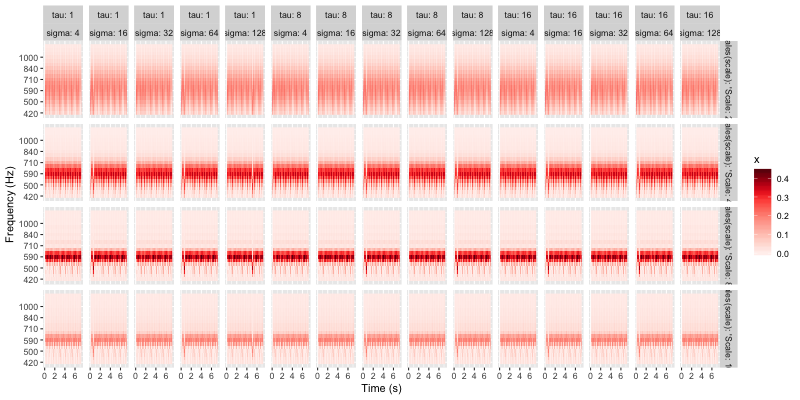

RObject{VecSxp}


In [230]:
rplot(result[2].sources.tracks)

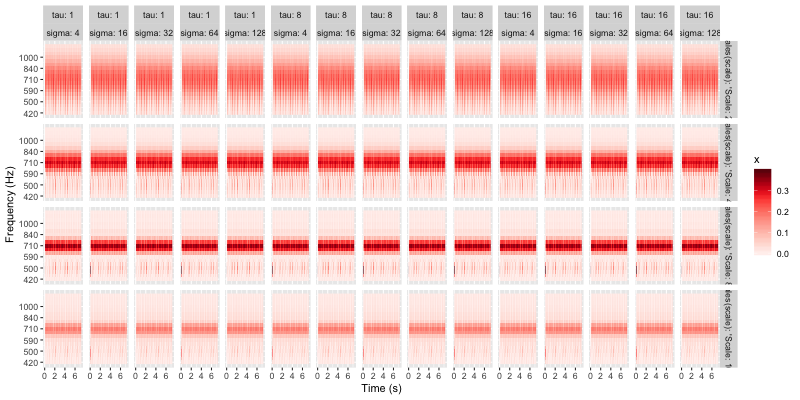

RObject{VecSxp}


In [231]:
rplot(result[3].sources.tracks)

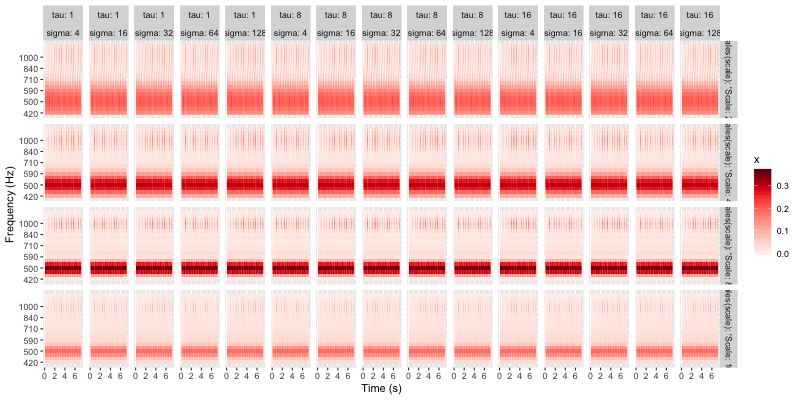

RObject{VecSxp}


In [232]:
rplot(result[4].sources.tracks)

## Discussion

Although the probabilities found by `pred` and `fpred` are consistent with my intuition, the consequences of the prior on this probability do not seem to be matching my intuition. I need to examine the effect of the prior on the measures and see if there is a reasonable aspect of the prior to maniuplate:
one obvious thing might be to alter the extent of the neighborhood in the correlation matrix: however this would invovle more computations.

Principally, by increasing the neibhord, basically all of the percepts are split. (Not that that with a narrower neighbord hood 1st percept fuses)

1. I might explore this by exmaining $\Delta f$ values closer to one another, as it seems like 3st, 6st an 12st are all essentially equivalent to one another still. Perhaps this would work if I just squeeze the delta t's. 

2. Another possibility is that I could examine the effect of the prior on `pred` and `fpred`.